## Demonstration of 1-D and 1-D time dilitated convolutions

in this notebook you will use 1D causal convolution to predict timeseries. You learn how 1D convolutions with causal padding work and see that dilated causal convolution are able capture long-range dependencies.

**Dataset:** We will use an articfical dataset with some long-range dependencies. We generate 1000 timeseries with the length of 128 timesteps that all follow the same pattern: a fast changing sine wave where the amplitude is modulated by an other sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. Our goal is to first predict the next 10 timesteps and then we want to predict for even longer timesteps in the future.

**Content:**
* creat articfical dataset with some long-range dependencies
* visualize a samples timeseries
* use keras to train a CNN with 1D causal convolutions
* predict the next 10 timesteps of the timeseries 
* predict the next 80 timesteps of the timeseries 
* use keras to train a CNN with 1D dilitated causal convolutions (which are abe to deal with long-range dependencies)
* predict the next 80 timesteps of the timeseries with 1D dilitated causal convolutions

In [0]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Lambda, Convolution1D
from tensorflow.keras.utils import to_categorical 


### Simulate some data

In the next cell we generate train and validation data. We multiply a fast sine wave with a slower sine wave and add a bit random noise. The goal is to learn from the past of time series and predict the next 10 steps and later even more than "only"  10 steps.

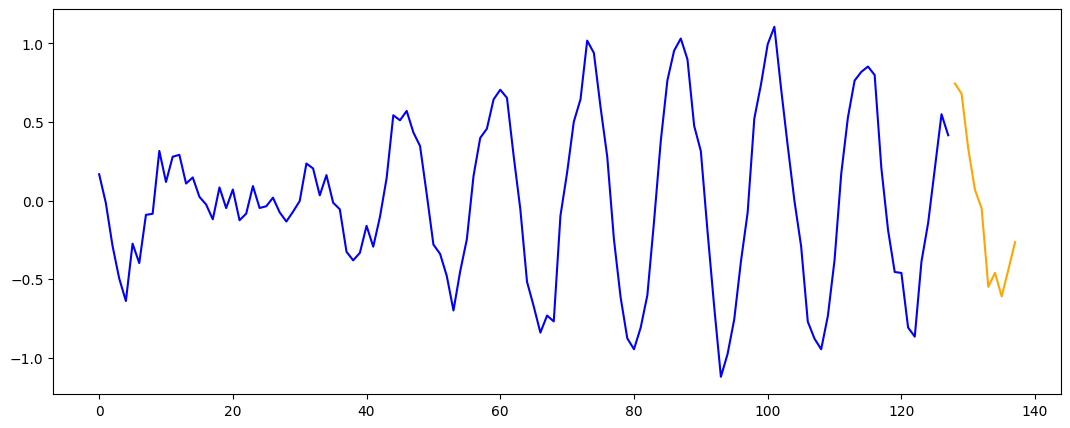

The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.


In [0]:
np.random.seed(1) # Fixing the seed, so data generation is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1,seq_length=128,look_ahead=10): # We create 1000 observations of the process
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(1):
  plt.figure(num=None, figsize=(13,5))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'b-',color='orange')

plt.show()
print('The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.')

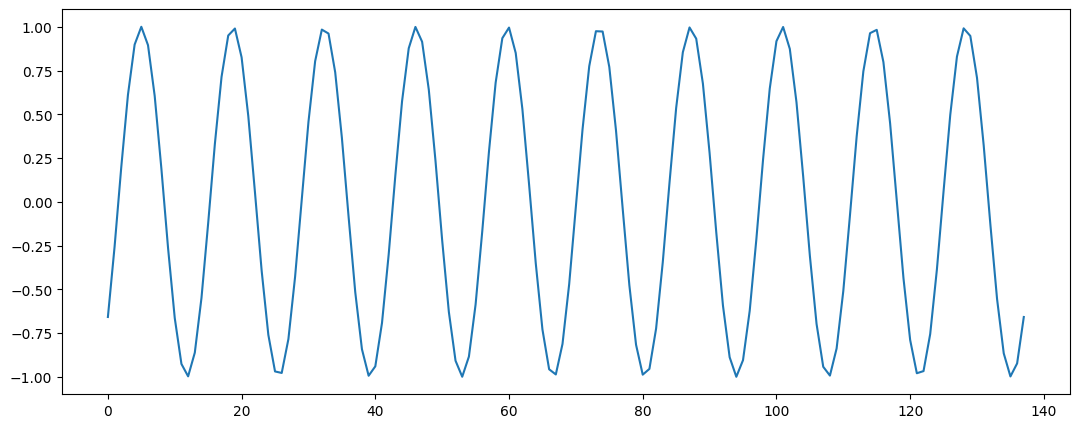

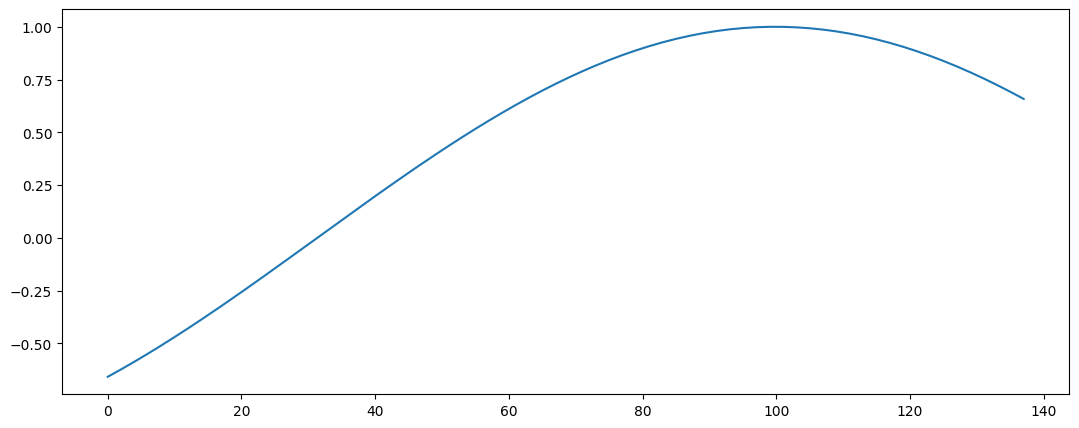

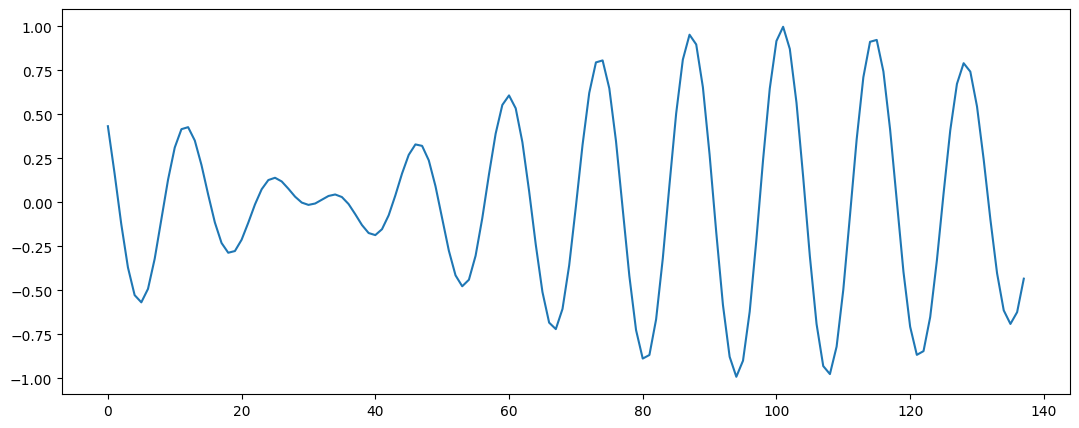

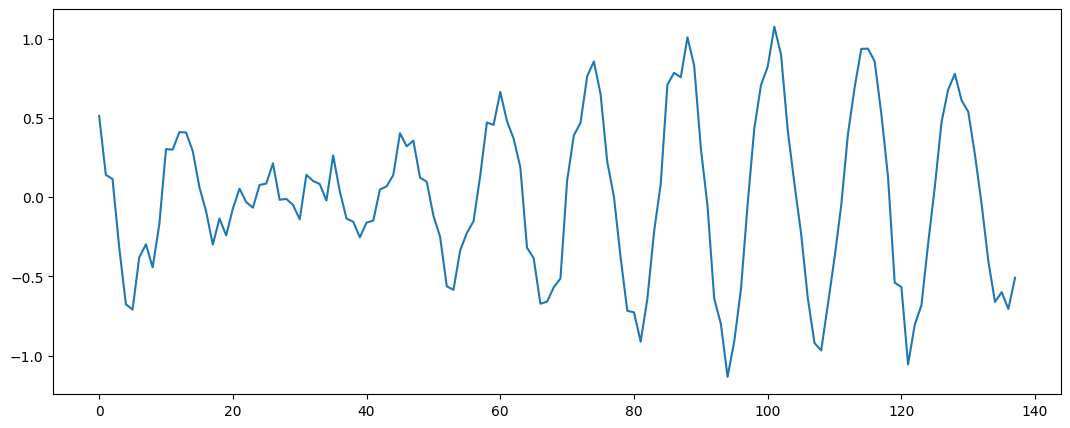

In [0]:
# process:fast sine wave * slow sine wave + random noise
start = np.random.uniform(0, 2*np.pi) # Random start point
s=128+10
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s))+np.random.normal(0,0.1,s))
plt.show()


In [0]:
print(X.shape)
print(Y.shape)

(1000, 128, 1)
(1000, 10, 1)


### 1D Convolution without dilation rate

Here we define a Neural network with 1D convolutions and "causal" padding, in a later step we will also use a dilation rate.

In [0]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]
  
model_1Dconv = Sequential()
ks = 5
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', input_shape=(128, 1)))
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_1Dconv.add(Dense(1))
model_1Dconv.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_1Dconv.compile(optimizer='adam', loss='mean_squared_error')
model_1Dconv.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 128, 32)           192       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 128, 32)           5152      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 128, 32)           5152      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 128, 32)           5152      
_________________________________________________________________
dense_4 (Dense)              (None, 128, 1)            33        
_________________________________________________________________
lambda_4 (Lambda)            (None, 10, 1)             0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
__________________________________________________

In [0]:
history = model_1Dconv.fit(X[0:800], Y[0:800],
                    epochs=50,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.0959 - val_loss: 0.0367
Epoch 2/50
800/800 [==============================] - 1s 649us/sample - loss: 0.0511 - val_loss: 0.0342
Epoch 3/50
800/800 [==============================] - 1s 642us/sample - loss: 0.0394 - val_loss: 0.0359
Epoch 4/50
800/800 [==============================] - 0s 613us/sample - loss: 0.0343 - val_loss: 0.0305
Epoch 5/50
800/800 [==============================] - 0s 620us/sample - loss: 0.0319 - val_loss: 0.0295
Epoch 6/50
800/800 [==============================] - 0s 610us/sample - loss: 0.0299 - val_loss: 0.0266
Epoch 7/50
800/800 [==============================] - 0s 615us/sample - loss: 0.0287 - val_loss: 0.0258
Epoch 8/50
800/800 [==============================] - 0s 623us/sample - loss: 0.0271 - val_loss: 0.0237
Epoch 9/50
800/800 [==============================] - 0s 623us/sample - loss: 0.0260 - val_loss: 0.0231
Epoch 10/50
800/800 

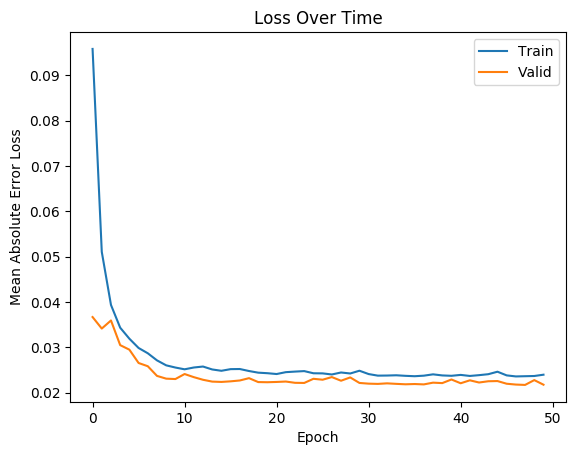

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

Now we want to use the trained model to predict for the next 10 steps, remember that is what the model was trained on.  
In addition,  we want to predict for longer than just 10 steps, we will  just predict the next 10 steps and take the predictions as new "true" observations and feed these values into the model, when we do that we can predict for any length we want. In the next cell we will predict the next 10 and 80 steps.

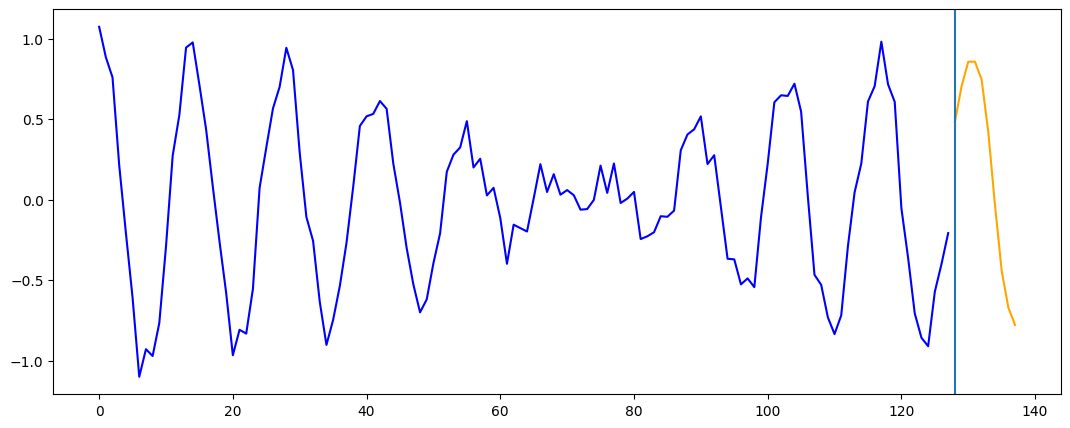

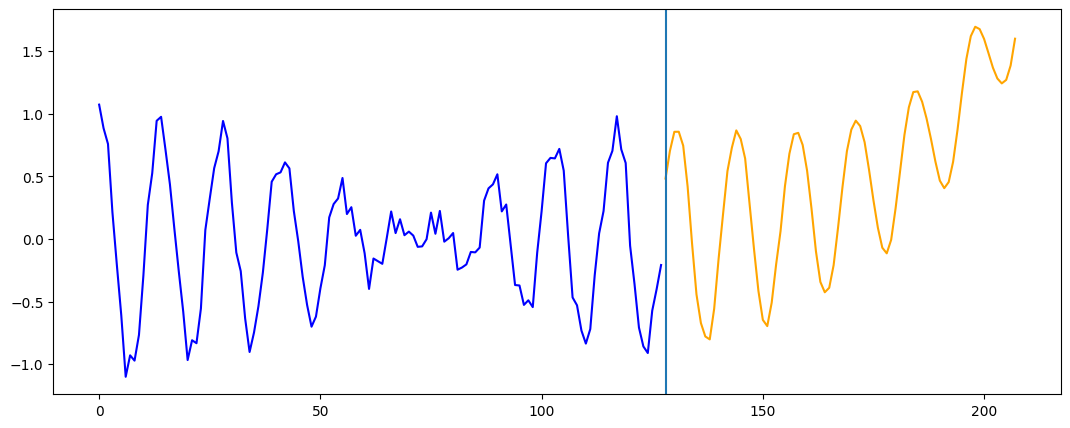

In [0]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### 1D Convolution with dilation rate


Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time.

In [0]:

model_1Dconv_w_d = Sequential()
ks = 5
##################################################
###### your code here#############################

model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', input_shape=(128, 1)))
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal',dilation_rate=2))
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal',dilation_rate=4))
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal',dilation_rate=8))
model_1Dconv_w_d.add(Dense(1))
model_1Dconv_w_d.add(Lambda(slice, arguments={'slice_length':look_ahead}))

###### end of your code ##########################
##################################################

model_1Dconv_w_d.compile(optimizer='adam', loss='mean_squared_error')
model_1Dconv_w_d.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 128, 32)           192       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 128, 32)           5152      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 128, 32)           5152      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 128, 32)           5152      
_________________________________________________________________
dense_5 (Dense)              (None, 128, 1)            33        
_________________________________________________________________
lambda_5 (Lambda)            (None, 10, 1)             0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
__________________________________________________

In [0]:
history = model_1Dconv_w_d.fit(X[0:800], Y[0:800],
                    epochs=50,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 2ms/sample - loss: 0.1619 - val_loss: 0.0495
Epoch 2/50
800/800 [==============================] - 1s 740us/sample - loss: 0.0409 - val_loss: 0.0242
Epoch 3/50
800/800 [==============================] - 1s 723us/sample - loss: 0.0215 - val_loss: 0.0158
Epoch 4/50
800/800 [==============================] - 1s 739us/sample - loss: 0.0153 - val_loss: 0.0148
Epoch 5/50
800/800 [==============================] - 1s 732us/sample - loss: 0.0153 - val_loss: 0.0133
Epoch 6/50
800/800 [==============================] - 1s 728us/sample - loss: 0.0135 - val_loss: 0.0126
Epoch 7/50
800/800 [==============================] - 1s 732us/sample - loss: 0.0130 - val_loss: 0.0122
Epoch 8/50
800/800 [==============================] - 1s 765us/sample - loss: 0.0128 - val_loss: 0.0120
Epoch 9/50
800/800 [==============================] - 1s 745us/sample - loss: 0.0126 - val_loss: 0.0120
Epoch 10/50
800/800 

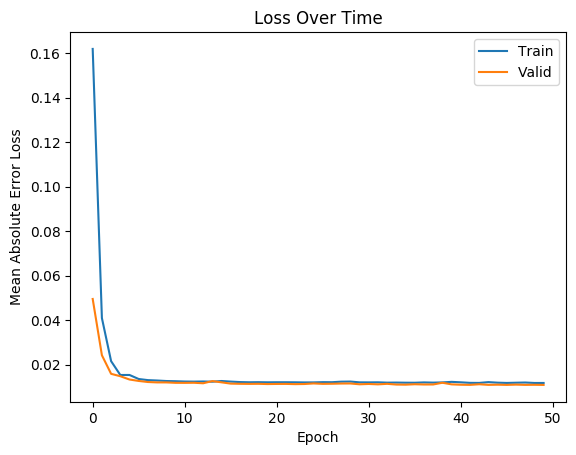

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

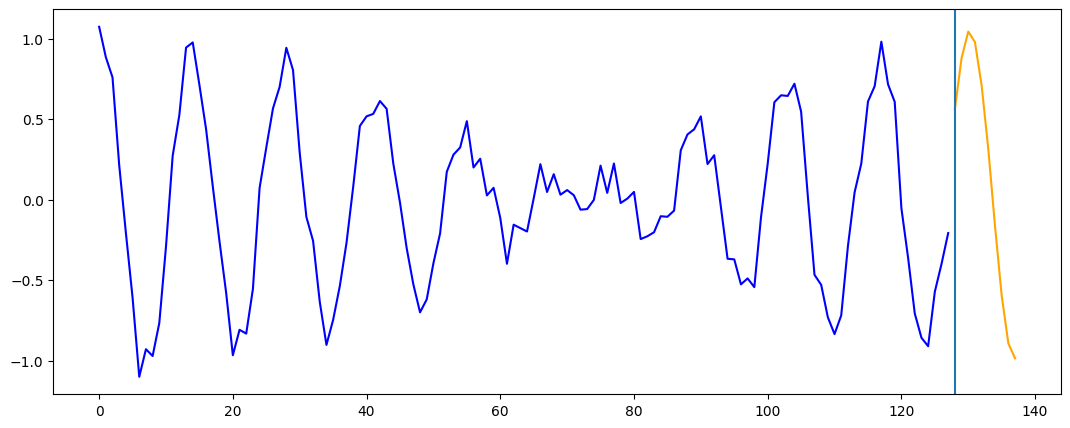

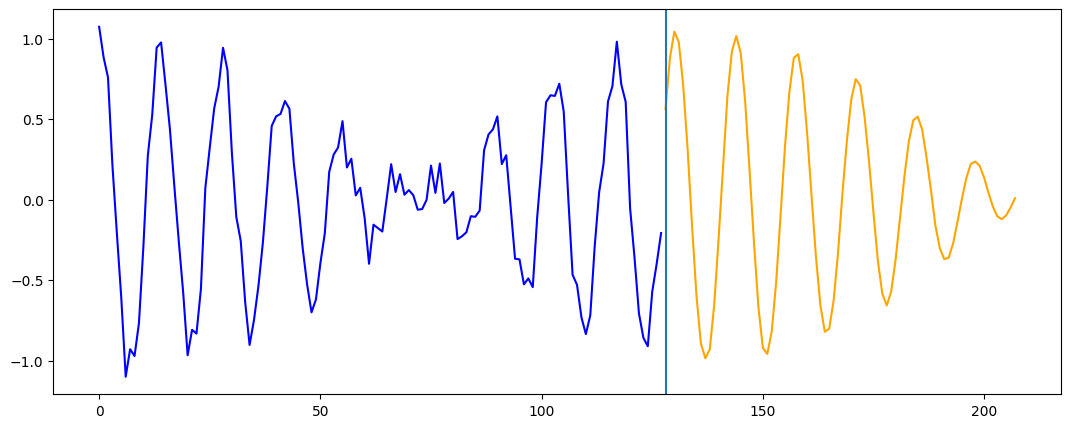

In [0]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



#### Exercise:
Compare the long time predictions of the 1D Convolutional netural network with and without dilation.  
What do you observe and how do you exlain it.